# Graph Networks
* given: coeefficient Matrix for Nodes and Weights
___
* draw network graph
* find solution using greedy search algorithm

In [1]:
# TODO: add kernel support to .venv; kernel currently set to ~/.pyenv/versions/3.10.4/bin/python
import numpy as np
import matplotlib.pyplot as plt

import pygraphviz
import networkx as nx
# requires pydot as a cross-dependency for nx

In [2]:
adjacency_matrix = [
    [0, 10, 5, 10, 5], 
    [14, 0, 7, 20, 7], 
    [10, 14, 0, 14, 10], 
    [7, 20, 7, 0, 14], 
    [5, 10, 5, 10, 0]
]

In [3]:
multigraph_matrix = nx.from_numpy_array(
    A=np.array(adjacency_matrix), 
    create_using=nx.MultiGraph
)

In [4]:
layout = nx.nx_pydot.graphviz_layout(multigraph_matrix)

/var/folders/4m/1hfc1mk90538tfnlfws7b36w0000gn/T/ipykernel_14993/4074669417.py:1: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  layout = nx.nx_pydot.graphviz_layout(multigraph_matrix)


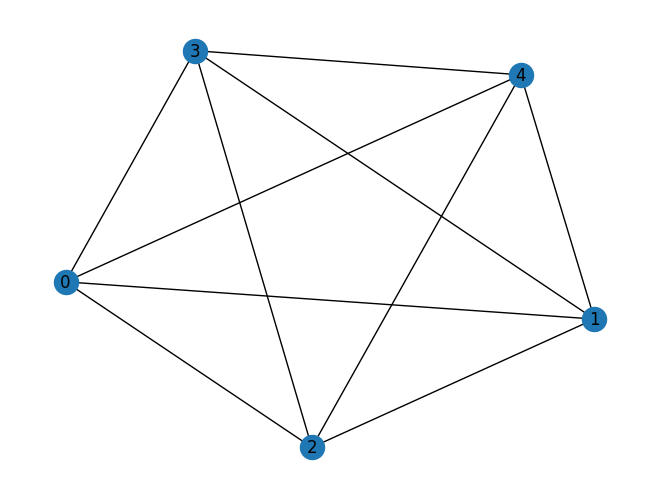

In [5]:
nx.draw(multigraph_matrix, layout, with_labels=True)

{(0, 1): Text(69.02000000000001, 48.4815, "{'weight': 10}"),
 (0, 2): Text(46.5675, 35.1715, "{'weight': 5}"),
 (0, 3): Text(37.2795, 76.3315, "{'weight': 10}"),
 (0, 4): Text(63.165, 73.821, "{'weight': 5}"),
 (1, 2): Text(88.5875, 31.31, "{'weight': 7}"),
 (1, 3): Text(79.2995, 72.47, "{'weight': 20}"),
 (1, 4): Text(105.185, 69.9595, "{'weight': 7}"),
 (2, 3): Text(56.847, 59.16, "{'weight': 14}"),
 (2, 4): Text(82.7325, 56.6495, "{'weight': 10}"),
 (3, 4): Text(73.4445, 97.8095, "{'weight': 14}")}

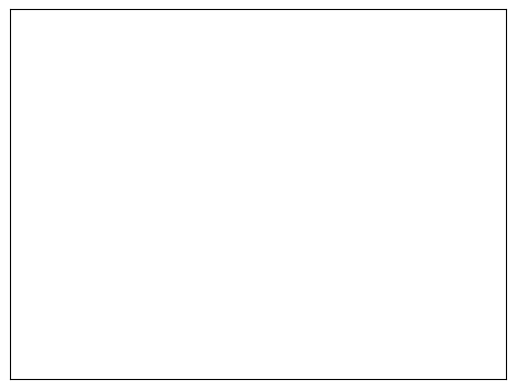

In [6]:
# TODO: make graph appear
nx.draw_networkx_edge_labels(multigraph_matrix, pos=layout)

In [7]:
# save and draw graph
A = nx.nx_agraph.to_agraph(multigraph_matrix)
A.layout()
A.draw('test.pdf')

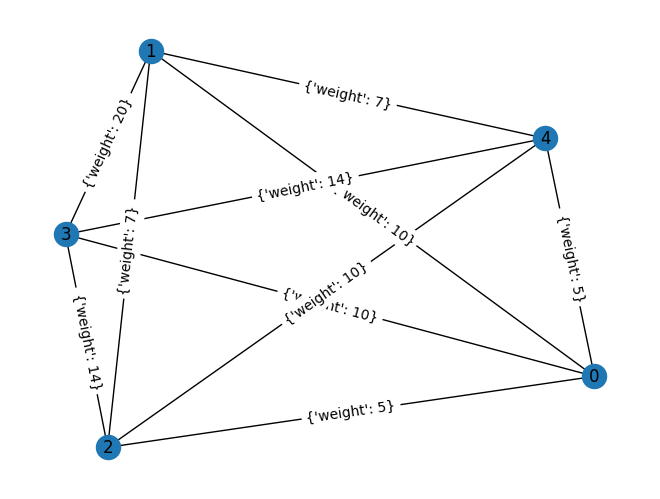

In [8]:
# nx.draw(multigraph_matrix, node_size = 800, node_color="cyan", with_labels = True)
layout = nx.spring_layout(multigraph_matrix)
nx.draw(multigraph_matrix, layout, with_labels=True)
nx.draw_networkx_edge_labels(multigraph_matrix, pos=layout)
plt.savefig('test_2.pdf')

## base implementation misum

In [10]:
import numpy as np

def calculate_cost(distance_matrix, route):
    """
    Calculates the total cost of a route based on the given distance matrix.
    """
    cost = 0
    for i in range(len(route) - 1):
        from_node = route[i]
        to_node = route[i + 1]
        cost += distance_matrix[from_node][to_node]
    return cost

def insertion_algorithm(distance_matrix, demands, vehicle_capacity, num_vehicles):
    num_nodes = len(distance_matrix)
    num_routes = min(num_vehicles, num_nodes - 1)  # Excluding the depot (node 0)

    # Initialize the routes and their current loads
    routes = [[] for _ in range(num_routes)]
    loads = [0] * num_routes

    # Sort the nodes by their demand in descending order
    sorted_nodes = sorted(range(1, num_nodes), key=lambda x: demands[x], reverse=True)

    for node in sorted_nodes:
        best_cost = float('inf')
        best_vehicle = -1
        best_position = -1

        # Iterate over all vehicles
        for vehicle in range(num_routes):
            # Iterate over all possible positions in the vehicle's route
            for position in range(len(routes[vehicle]) + 1):
                current_load = loads[vehicle] + demands[node]
                if current_load > vehicle_capacity:
                    continue

                # Insert the node at the position and calculate the cost
                route = routes[vehicle].copy()
                route.insert(position, node)
                cost = calculate_cost(distance_matrix, [0] + route + [0])

                # Update the best cost, vehicle, and position if the cost is lower
                if cost < best_cost:
                    best_cost = cost
                    best_vehicle = vehicle
                    best_position = position

        # Insert the node into the best vehicle and position
        routes[best_vehicle].insert(best_position, node)
        loads[best_vehicle] += demands[node]

    return routes

# Example usage
distance_matrix = np.array([
    [0, 10, 5, 10, 5],
    [14, 0, 7, 20, 7],
    [10, 14, 0, 14, 10],
    [7, 20, 7, 0, 14],
    [5, 10, 5, 10, 0]
])
demands = [0, 2, 4, 3, 1]  # Demands at nodes (excluding the depot)
vehicle_capacity = 6  # Capacity of each vehicle
num_vehicles = 2  # Number of vehicles

routes = insertion_algorithm(distance_matrix, demands, vehicle_capacity, num_vehicles)
print(routes)


[[1, 2], [4, 3]]


# with feasibilities

In [4]:
import numpy as np

def calculate_cost(distance_matrix, route):
    """
    Calculates the total cost of a route based on the given distance matrix.
    """
    cost = 0
    for i in range(len(route) - 1):
        from_node = route[i]
        to_node = route[i + 1]
        cost += distance_matrix[from_node][to_node]
    return cost

def calculate_insertion_cost(distance_matrix, route, position, node):
    """
    Calculates the cost of inserting a node into a route at a specific position
    based on the given distance matrix.
    """
    if position == 0:
        from_node = 0
    else:
        from_node = route[position - 1]
    to_node = route[position] if position < len(route) else 0  # The depot node (node 0)
    insertion_cost = distance_matrix[from_node][node] + distance_matrix[node][to_node] - distance_matrix[from_node][to_node]
    return insertion_cost

def insertion_algorithm(distance_matrix, demands, vehicle_capacity, num_vehicles, infeasible_nodes):
    num_nodes = len(distance_matrix)
    num_routes = min(num_vehicles, num_nodes - 1)  # Excluding the depot (node 0)

    # Initialize the routes and their current loads
    routes = [[] for _ in range(num_routes)]
    loads = [0] * num_routes

    # Sort the nodes by their demand in descending order
    sorted_nodes = sorted(range(1, num_nodes), key=lambda x: demands[x], reverse=True)

    for node in sorted_nodes:
        best_cost = float('inf')
        best_vehicle = -1
        best_position = -1

        # Iterate over all vehicles
        for vehicle in range(num_routes):
            print(f'vehicle {vehicle}, node {node}')
            if vehicle in infeasible_nodes and node in infeasible_nodes[vehicle]:
                print('\tforbidden')
                continue
            print('continued')
            # Iterate over all possible positions in the vehicle's route
            for position in range(len(routes[vehicle]) + 1):
                print(f'\t\tposition: {position}')
                current_load = loads[vehicle] + demands[node]
                if current_load > vehicle_capacity:
                    continue

                # Calculate the cost of inserting the node at the position
                insertion_cost = calculate_insertion_cost(distance_matrix, routes[vehicle], position, node)

                # Update the best cost, vehicle, and position if the cost is lower
                if insertion_cost < best_cost:
                    best_cost = insertion_cost
                    best_vehicle = vehicle
                    best_position = position
                    print(f'\t\t\tinsertion: node: {node}, vehicle: {best_vehicle}, position: {best_position}, cost: {best_cost}')

        # Insert the node into the best vehicle and position
        if best_vehicle != -1: 
            routes[best_vehicle].insert(best_position, node)
            loads[best_vehicle] += demands[node]

    return routes

# Example usage
distance_matrix = np.array([
    [0,  10,  5, 10, 5],
    [10,  0,  7, 20, 7],
    [5,   7,  0, 14, 10],
    [10, 20, 14,  0, 14],
    [5,   7, 10, 14,  0]
])
demands = [0, 2, 1, 3, 1]  # Demands at nodes (excluding the depot)
vehicle_capacity = 6  # Capacity of each vehicle
num_vehicles = 2  # Number of vehicles

infeasible_nodes = {
    0: [1],  # Nodes that vehicle 0 cannot visit
    1: [3, 4]   # Nodes that vehicle 1 cannot visit
}

routes = insertion_algorithm(distance_matrix, demands, vehicle_capacity, num_vehicles, infeasible_nodes)

# Print vehicles and routes
for i, route in enumerate(routes):
    vehicle = i + 1
    cost = calculate_cost(distance_matrix, [0] + route + [0])
    print(f"Vehicle {vehicle} - Route: [0]", end=" -> ")
    for node in route:
        print(f"Node {node}", end=" -> ")
    print("[0], Cost:", cost)



vehicle 0, node 3
continued
		position: 0
			insertion: node: 3, vehicle: 0, position: 0, cost: 20
vehicle 1, node 3
	forbidden
vehicle 0, node 1
	forbidden
vehicle 1, node 1
continued
		position: 0
			insertion: node: 1, vehicle: 1, position: 0, cost: 20
vehicle 0, node 2
continued
		position: 0
			insertion: node: 2, vehicle: 0, position: 0, cost: 9
		position: 1
vehicle 1, node 2
continued
		position: 0
			insertion: node: 2, vehicle: 1, position: 0, cost: 2
		position: 1
vehicle 0, node 4
continued
		position: 0
			insertion: node: 4, vehicle: 0, position: 0, cost: 9
		position: 1
vehicle 1, node 4
	forbidden
Vehicle 1 - Route: [0] -> Node 4 -> Node 3 -> [0], Cost: 29
Vehicle 2 - Route: [0] -> Node 2 -> Node 1 -> [0], Cost: 22


### with deadlines

In [72]:
import numpy as np

def calculate_cost(distance_matrix, route):
    """
    Calculates the total cost of a route based on the given distance matrix.
    """
    cost = 0
    for i in range(len(route) - 1):
        from_node = route[i]
        to_node = route[i + 1]
        cost += distance_matrix[from_node][to_node]
    return cost

def calculate_insertion_cost(distance_matrix, route, position, node):
    """
    Calculates the cost of inserting a node into a route at a specific position
    based on the given distance matrix.
    """
    if position == 0:
        from_node = 0
    else:
        from_node = route[position - 1]
    to_node = route[position]
    insertion_cost = distance_matrix[from_node][node] + distance_matrix[node][to_node] - distance_matrix[from_node][to_node]
    return insertion_cost

def insertion_algorithm(distance_matrix, demands, vehicle_capacity, num_vehicles, infeasible_nodes, deadlines):
    num_nodes = len(distance_matrix)
    num_routes = min(num_vehicles, num_nodes - 1)  # Excluding the depot (node 0)

    # Initialize the routes and their current loads
    routes = [[] for _ in range(num_routes)]
    loads = [0] * num_routes

    # Sort the nodes by their demand in descending order
    sorted_nodes = sorted(range(1, num_nodes), key=lambda x: demands[x], reverse=True)

    for node in sorted_nodes:
        best_cost = float('inf')
        best_vehicle = -1
        best_position = -1

        # Iterate over all vehicles
        for vehicle in range(num_routes):
            if node in infeasible_nodes[vehicle]:
                continue

            # Iterate over all possible positions in the vehicle's route
            for position in range(len(routes[vehicle]) + 1):
                current_load = loads[vehicle] + demands[node]
                if current_load > vehicle_capacity:
                    continue

                # Calculate the cost of inserting the node at the position
                insertion_cost = calculate_insertion_cost(distance_matrix, routes[vehicle], position, node)

                # Consider the deadline of the node
                deadline = deadlines[node]
                if deadline is not None:
                    if len(routes[vehicle]) + 1 > deadline:
                        insertion_cost += (len(routes[vehicle]) + 1 - deadline) * 1000

                # Update the best cost, vehicle, and position if the cost is lower
                if insertion_cost < best_cost:
                    best_cost = insertion_cost
                    best_vehicle = vehicle
                    best_position = position

        # Insert the node into the best vehicle and position
        routes[best_vehicle].insert(best_position, node)
        loads[best_vehicle] += demands[node]

    return routes

# Example usage
distance_matrix = np.array([
    [0, 10, 5, 10, 5],
    [14, 0, 7, 20, 7],
    [10, 14, 0, 14, 10],
    [7, 20, 7, 0, 14],
    [5, 10, 5, 10, 0]
])
demands = [0, 2, 4, 3, 1]  # Demands at nodes (excluding the depot)
vehicle_capacity = 6  # Capacity of each vehicle
num_vehicles = 2  # Number of vehicles

infeasible_nodes = {
    0: [3],  # Nodes that vehicle 0 cannot visit
    1: [4]   # Nodes that vehicle 1 cannot visit
}

deadlines = {
    1: 4,  # Deadline for node 1 (to be visited before the 4th timestep)
    2: 10  # Deadline for node 2 (to be visited before the 10th timestep)
}

routes = insertion_algorithm(distance_matrix, demands, vehicle_capacity, num_vehicles, infeasible_nodes, deadlines)
print(routes)


IndexError: list index out of range

In [22]:
import numpy as np

def calculate_cost(distance_matrix, route):
    """
    Calculates the total cost of a route based on the given distance matrix.
    """
    cost = 0
    for i in range(len(route) - 1):
        from_node = route[i]
        to_node = route[i + 1]
        cost += distance_matrix[from_node][to_node]
    return cost

def calculate_insertion_cost(distance_matrix, route, position, node):
    """
    Calculates the cost of inserting a node into a route at a specific position
    based on the given distance matrix.
    """
    if position == 0:
        from_node = 0
    else:
        from_node = route[position - 1]
    to_node = route[position] if position < len(route) else 0  # The depot node (node 0)
    insertion_cost = distance_matrix[from_node][node] + distance_matrix[node][to_node] - distance_matrix[from_node][to_node]
    return insertion_cost

def insertion_algorithm(distance_matrix, demands, vehicle_capacity, num_vehicles, infeasible_nodes, deadlines):
    num_nodes = len(distance_matrix)
    num_routes = min(num_vehicles, num_nodes - 1)  # Excluding the depot (node 0)

    # Initialize the routes and their current loads
    routes = [[] for _ in range(num_routes)]
    loads = [0] * num_routes

    # Sort the nodes by their demand in descending order
    sorted_nodes = sorted(range(1, num_nodes), key=lambda x: demands[x], reverse=True)

    for node in sorted_nodes:
        best_cost = float('inf')
        best_vehicle = -1
        best_position = -1

        # Iterate over all vehicles
        for vehicle in range(num_routes):
            if node in infeasible_nodes[vehicle]:
                continue

            # Iterate over all possible positions in the vehicle's route
            for position in range(len(routes[vehicle]) + 1):
                current_load = loads[vehicle] + demands[node]
                if current_load > vehicle_capacity:
                    continue

                # Calculate the cost of inserting the node at the position
                insertion_cost = calculate_insertion_cost(distance_matrix, routes[vehicle], position, node)

                # Consider the deadline of the node
                print(f'node: {node}, deadline: {deadlines[node]}')
                deadline = deadlines[node]
                if deadline is not None:
                    if len(routes[vehicle]) + 1 > deadline:
                        insertion_cost += (len(routes[vehicle]) + 1 - deadline) * 1000

                # Update the best cost, vehicle, and position if the cost is lower
                if insertion_cost < best_cost:
                    best_cost = insertion_cost
                    best_vehicle = vehicle
                    best_position = position

        # Insert the node into the best vehicle and position
        routes[best_vehicle].insert(best_position, node)
        loads[best_vehicle] += demands[node]

    return routes

# Example usage
distance_matrix = np.array([
    [0, 10, 5, 10, 5],
    [14, 0, 7, 20, 7],
    [10, 14, 0, 14, 10],
    [7, 20, 7, 0, 14],
    [5, 10, 5, 10, 0]
])
demands = [0, 2, 4, 3, 1]  # Demands at nodes (excluding the depot)
vehicle_capacity = 6  # Capacity of each vehicle
num_vehicles = 2  # Number of vehicles

infeasible_nodes = {
    0: [3],  # Nodes that vehicle 0 cannot visit
    1: [4]   # Nodes that vehicle 1 cannot visit
}

deadlines = {
    1: 4,  # Deadline for node 1 (to be visited before the 4th timestep)
    2: 10,  # Deadline for node 2 (to be visited before the 10th timestep)
    3: 20,
    4: 25
}

routes = insertion_algorithm(distance_matrix, demands, vehicle_capacity, num_vehicles, infeasible_nodes, deadlines)
print(routes)


node: 2, deadline: 10
node: 2, deadline: 10
node: 3, deadline: 20
node: 1, deadline: 4
node: 1, deadline: 4
node: 1, deadline: 4
node: 1, deadline: 4
[[1, 2], [4, 3]]


In [29]:
import numpy as np

def calculate_cost(distance_matrix, route):
    """
    Calculates the total cost of a route based on the given distance matrix.
    """
    cost = 0
    for i in range(len(route) - 1):
        from_node = route[i]
        to_node = route[i + 1]
        cost += distance_matrix[from_node][to_node]
    return cost

def calculate_insertion_cost(distance_matrix, route, position, node):
    """
    Calculates the cost of inserting a node into a route at a specific position
    based on the given distance matrix.
    """
    if position == 0:
        from_node = 0
    else:
        from_node = route[position - 1]
    to_node = route[position] if position < len(route) else 0  # The depot node (node 0)
    insertion_cost = distance_matrix[from_node][node] + distance_matrix[node][to_node] - distance_matrix[from_node][to_node]
    return insertion_cost

def insertion_algorithm(distance_matrix, demands, vehicle_capacity, num_vehicles, infeasible_nodes, deadlines):
    num_nodes = len(distance_matrix)
    num_routes = min(num_vehicles, num_nodes - 1)  # Excluding the depot (node 0)

    # Initialize the routes and their current loads
    routes = [[] for _ in range(num_routes)]
    loads = [0] * num_routes

    # Sort the nodes by their demand in descending order
    sorted_nodes = sorted(range(1, num_nodes), key=lambda x: demands[x], reverse=True)

    for node in sorted_nodes:
        best_cost = float('inf')
        best_vehicle = -1
        best_position = -1

        # Iterate over all vehicles
        for vehicle in range(num_routes):
            if node in infeasible_nodes[vehicle]:
                continue

            # Iterate over all possible positions in the vehicle's route
            for position in range(len(routes[vehicle]) + 1):
                current_load = loads[vehicle] + demands[node]
                if current_load > vehicle_capacity:
                    continue

                # Calculate the cost of inserting the node at the position
                insertion_cost = calculate_insertion_cost(distance_matrix, routes[vehicle], position, node)

                # Consider the deadline of the node
                deadline = deadlines[node]
                if deadline is not None:
                    if len(routes[vehicle]) + 1 > deadline:
                        insertion_cost += (len(routes[vehicle]) + 1 - deadline) * 1000

                # Update the best cost, vehicle, and position if the cost is lower
                if insertion_cost < best_cost:
                    best_cost = insertion_cost
                    best_vehicle = vehicle
                    best_position = position

        # Insert the node into the best vehicle and position
        routes[best_vehicle].insert(best_position, node)
        loads[best_vehicle] += demands[node]

    return routes

# Example usage
distance_matrix = np.array([
    [0, 10, 5, 10, 5],
    [14, 0, 7, 20, 7],
    [10, 14, 0, 14, 10],
    [7, 20, 7, 0, 14],
    [5, 10, 5, 10, 0]
])
demands = [0, 2, 4, 3, 1]  # Demands at nodes (excluding the depot)
vehicle_capacity = 6  # Capacity of each vehicle
num_vehicles = 2  # Number of vehicles

infeasible_nodes = {
    0: [3],  # Nodes that vehicle 0 cannot visit
    1: [4]   # Nodes that vehicle 1 cannot visit
}

deadlines = {
    1: 4,  # Deadline for node 1 (to be visited before the 4th timestep)
    2: 10, # Deadline for node 2 (to be visited before the 10th timestep)
    3: None # Node 3 has no deadline
}

routes = insertion_algorithm(distance_matrix, demands, vehicle_capacity, num_vehicles, infeasible_nodes, deadlines)
print(routes)


[[1, 2], [4, 3]]


In [30]:
import numpy as np

def calculate_cost(distance_matrix, route):
    """
    Calculates the total cost of a route based on the given distance matrix.
    """
    cost = 0
    for i in range(len(route) - 1):
        from_node = route[i]
        to_node = route[i + 1]
        cost += distance_matrix[from_node][to_node]
    return cost

def calculate_insertion_cost(distance_matrix, route, position, node):
    """
    Calculates the cost of inserting a node into a route at a specific position
    based on the given distance matrix.
    """
    if position == 0:
        from_node = 0
    else:
        from_node = route[position - 1]
    to_node = route[position] if position < len(route) else 0  # The depot node (node 0)
    insertion_cost = distance_matrix[from_node][node] + distance_matrix[node][to_node] - distance_matrix[from_node][to_node]
    return insertion_cost

def insertion_algorithm(distance_matrix, demands, vehicle_capacity, num_vehicles, infeasible_nodes, deadlines):
    num_nodes = len(distance_matrix)
    num_routes = min(num_vehicles, num_nodes - 1)  # Excluding the depot (node 0)

    # Initialize the routes and their current loads
    routes = [[] for _ in range(num_routes)]
    loads = [0] * num_routes

    # Sort the nodes by their demand in descending order
    sorted_nodes = sorted(range(1, num_nodes), key=lambda x: demands[x], reverse=True)

    for node in sorted_nodes:
        best_cost = float('inf')
        best_vehicle = -1
        best_position = -1

        # Iterate over all vehicles
        for vehicle in range(num_routes):
            if node in infeasible_nodes[vehicle]:
                continue

            # Iterate over all possible positions in the vehicle's route
            for position in range(len(routes[vehicle]) + 1):
                current_load = loads[vehicle] + demands[node]
                if current_load > vehicle_capacity:
                    continue

                # Calculate the cost of inserting the node at the position
                insertion_cost = calculate_insertion_cost(distance_matrix, routes[vehicle], position, node)

                # Consider the deadline of the node
                deadline = deadlines[node]
                if deadline is not None:
                    if len(routes[vehicle]) + 1 > deadline:
                        insertion_cost += (len(routes[vehicle]) + 1 - deadline) * 1000

                # Update the best cost, vehicle, and position if the cost is lower
                if insertion_cost < best_cost:
                    best_cost = insertion_cost
                    best_vehicle = vehicle
                    best_position = position

        # Insert the node into the best vehicle and position
        routes[best_vehicle].insert(best_position, node)
        loads[best_vehicle] += demands[node]

    return routes

# Example usage
distance_matrix = np.array([
    [0, 10, 5, 10, 5],
    [14, 0, 7, 20, 7],
    [10, 14, 0, 14, 10],
    [7, 20, 7, 0, 14],
    [5, 10, 5, 10, 0]
])
demands = [0, 2, 4, 3, 1]  # Demands at nodes (excluding the depot)
vehicle_capacity = 6  # Capacity of each vehicle
num_vehicles = 2  # Number of vehicles

infeasible_nodes = {
    0: [3],  # Nodes that vehicle 0 cannot visit
    1: [4]   # Nodes that vehicle 1 cannot visit
}

deadlines = {
    1: 4,  # Deadline for node 1 (to be visited before the 4th timestep)
    2: 10, # Deadline for node 2 (to be visited before the 10th timestep)
    3: None # Node 3 has no deadline
}

routes = insertion_algorithm(distance_matrix, demands, vehicle_capacity, num_vehicles, infeasible_nodes, deadlines)

# Print vehicles, routes, and costs
for i, route in enumerate(routes):
    vehicle = i + 1
    cost = calculate_cost(distance_matrix, [0] + route + [0])
    print(f"Vehicle {vehicle} Route: [0] -> {route} -> [0], Cost: {cost}")



Vehicle 1 Route: [0] -> [1, 2] -> [0], Cost: 27
Vehicle 2 Route: [0] -> [4, 3] -> [0], Cost: 22


In [31]:
import numpy as np

def calculate_cost(distance_matrix, route):
    """
    Calculates the total cost of a route based on the given distance matrix.
    """
    cost = 0
    for i in range(len(route) - 1):
        from_node = route[i]
        to_node = route[i + 1]
        cost += distance_matrix[from_node][to_node]
    return cost

def calculate_insertion_cost(distance_matrix, route, position, node):
    """
    Calculates the cost of inserting a node into a route at a specific position
    based on the given distance matrix.
    """
    if position == 0:
        from_node = 0
    else:
        from_node = route[position - 1]
    to_node = route[position] if position < len(route) else 0  # The depot node (node 0)
    insertion_cost = distance_matrix[from_node][node] + distance_matrix[node][to_node] - distance_matrix[from_node][to_node]
    return insertion_cost

def insertion_algorithm(distance_matrix, demands, vehicle_capacity, num_vehicles, infeasible_nodes, deadlines):
    num_nodes = len(distance_matrix)
    num_routes = min(num_vehicles, num_nodes - 1)  # Excluding the depot (node 0)

    # Initialize the routes and their current loads
    routes = [[] for _ in range(num_routes)]
    loads = [0] * num_routes
    timesteps = [1] * num_routes

    # Sort the nodes by their demand in descending order
    sorted_nodes = sorted(range(1, num_nodes), key=lambda x: demands[x], reverse=True)

    for node in sorted_nodes:
        best_cost = float('inf')
        best_vehicle = -1
        best_position = -1

        # Iterate over all vehicles
        for vehicle in range(num_routes):
            if node in infeasible_nodes[vehicle]:
                continue

            # Iterate over all possible positions in the vehicle's route
            for position in range(len(routes[vehicle]) + 1):
                current_load = loads[vehicle] + demands[node]
                if current_load > vehicle_capacity:
                    continue

                # Calculate the cost of inserting the node at the position
                insertion_cost = calculate_insertion_cost(distance_matrix, routes[vehicle], position, node)

                # Consider the deadline of the node
                deadline = deadlines[node]
                if deadline is not None:
                    if timesteps[vehicle] + position + 1 > deadline:
                        insertion_cost += (timesteps[vehicle] + position + 1 - deadline) * 1000

                # Update the best cost, vehicle, and position if the cost is lower
                if insertion_cost < best_cost:
                    best_cost = insertion_cost
                    best_vehicle = vehicle
                    best_position = position

        # Insert the node into the best vehicle and position
        routes[best_vehicle].insert(best_position, node)
        loads[best_vehicle] += demands[node]
        timesteps[best_vehicle] += 1

    return routes, timesteps

# Example usage
distance_matrix = np.array([
    [0, 10, 5, 10, 5],
    [14, 0, 7, 20, 7],
    [10, 14, 0, 14, 10],
    [7, 20, 7, 0, 14],
    [5, 10, 5, 10, 0]
])
demands = [0, 2, 4, 3, 1]  # Demands at nodes (excluding the depot)
vehicle_capacity = 6  # Capacity of each vehicle
num_vehicles = 2  # Number of vehicles

infeasible_nodes = {
    0: [3],  # Nodes that vehicle 0 cannot visit
    1: [4]   # Nodes that vehicle 1 cannot visit
}

deadlines = {
    1: 4,  # Deadline for node 1 (to be visited before the 4th timestep)
    2: 10, # Deadline for node 2 (to be visited before the 10th timestep)
    3: None # Node 3 has no deadline
}

routes, timesteps = insertion_algorithm(distance_matrix, demands, vehicle_capacity, num_vehicles, infeasible_nodes, deadlines)

# Print vehicles, routes, timesteps, and costs
for i, route in enumerate(routes):
    vehicle = i + 1
    cost = calculate_cost(distance_matrix, [0] + route + [0])
    print(f"Vehicle {vehicle} - Route: [0] -> {route} -> [0], Timesteps: {timesteps[i]}, Cost: {cost}")


Vehicle 1 - Route: [0] -> [1, 2] -> [0], Timesteps: 3, Cost: 27
Vehicle 2 - Route: [0] -> [4, 3] -> [0], Timesteps: 3, Cost: 22


In [51]:
import numpy as np

def calculate_cost(distance_matrix, route):
    """
    Calculates the total cost of a route based on the given distance matrix.
    """
    cost = 0
    for i in range(len(route) - 1):
        from_node = route[i]
        to_node = route[i + 1]
        cost += distance_matrix[from_node][to_node]
    return cost

def calculate_insertion_cost(distance_matrix, route, position, node):
    """
    Calculates the cost of inserting a node into a route at a specific position
    based on the given distance matrix.
    """
    if position == 0:
        from_node = 0
    else:
        from_node = route[position - 1]
    to_node = route[position] if position < len(route) else 0  # The depot node (node 0)
    insertion_cost = distance_matrix[from_node][node] + distance_matrix[node][to_node] - distance_matrix[from_node][to_node]
    return insertion_cost

def insertion_algorithm(distance_matrix, demands, vehicle_capacity, num_vehicles, infeasible_nodes, deadlines):
    num_nodes = len(distance_matrix)
    num_routes = min(num_vehicles, num_nodes - 1)  # Excluding the depot (node 0)

    # Initialize the routes and their current loads
    routes = [[] for _ in range(num_routes)]
    loads = [0] * num_routes
    timesteps = [[1] for _ in range(num_routes)]

    # Sort the nodes by their demand in descending order
    sorted_nodes = sorted(range(1, num_nodes), key=lambda x: demands[x], reverse=True)

    for node in sorted_nodes:
        print(f'node: {node}')
        best_cost = float('inf')
        best_vehicle = -1
        best_position = -1

        # Iterate over all vehicles
        for vehicle in range(num_routes):
            print(f'\tvehicle: {vehicle}')
            if node in infeasible_nodes[vehicle]:
                print(f'\t\tinfeasible node detected; continuing')
                continue

            # Iterate over all possible positions in the vehicle's route
            for position in range(len(routes[vehicle]) + 1):
                print(f'\t\tdemands of node: {demands[node]}')
                current_load = loads[vehicle] + demands[node]
                if current_load > vehicle_capacity:
                    print(f'\t\tdemands exceeding vehicle capacity; continuing')
                    continue

                # Calculate the cost of inserting the node at the position
                insertion_cost = calculate_insertion_cost(distance_matrix, routes[vehicle], position, node)
                print(f'\t\t insertion_cost: {insertion_cost}')
                # Consider the deadline of the node
                deadline = deadlines[node]
                print(f'\t\tdeadline: {deadline}')
                if deadline is not None:
                    if timesteps[vehicle][position] + 1 > deadline:
                        insertion_cost += (timesteps[vehicle][position] + 1 - deadline) * 1000

                # Update the best cost, vehicle, and position if the cost is lower
                if insertion_cost < best_cost:
                    best_cost = insertion_cost
                    best_vehicle = vehicle
                    best_position = position

        # Insert the node into the best vehicle and position
        routes[best_vehicle].insert(best_position, node)
        loads[best_vehicle] += demands[node]
        timesteps[best_vehicle].insert(best_position, timesteps[best_vehicle][best_position] + 1)

    return routes, timesteps

# Example usage
distance_matrix = np.array([
    [0, 10, 5, 10, 5],
    [14, 0, 7, 20, 7],
    [10, 14, 0, 14, 10],
    [7, 20, 7, 0, 14],
    [5, 10, 5, 10, 0]
])
demands = [0, 2, 4, 3, 1]  # Demands at nodes (excluding the depot)
vehicle_capacity = 6  # Capacity of each vehicle
num_vehicles = 2  # Number of vehicles

infeasible_nodes = {
    0: [3],  # Nodes that vehicle 0 cannot visit
    1: [4]   # Nodes that vehicle 1 cannot visit
}

deadlines = {
    1: 4,  # Deadline for node 1 (to be visited before the 4th timestep)
    2: 10, # Deadline for node 2 (to be visited before the 10th timestep)
    3: None # Node 3 has no deadline
}

routes, timesteps = insertion_algorithm(distance_matrix, demands, vehicle_capacity, num_vehicles, infeasible_nodes, deadlines)

# Print vehicles, routes, node IDs, timesteps, and costs
for i, route in enumerate(routes):
    vehicle = i + 1
    cost = calculate_cost(distance_matrix, [0] + route + [0])
    print(f"Vehicle {vehicle} - Route: [0]", end=" -> ")
    for node, timestep in zip(route, timesteps[i]):
        print(f"Node {node} (Timestep {timestep})", end=" -> ")
    print("[0], Cost:", cost)


node: 2
	vehicle: 0
		demands of node: 4
		 insertion_cost: 15
		deadline: 10
	vehicle: 1
		demands of node: 4
		 insertion_cost: 15
		deadline: 10
node: 3
	vehicle: 0
		infeasible node detected; continuing
	vehicle: 1
		demands of node: 3
		 insertion_cost: 17
		deadline: None
node: 1
	vehicle: 0
		demands of node: 2
		 insertion_cost: 12
		deadline: 4
		demands of node: 2
		 insertion_cost: 18
		deadline: 4
	vehicle: 1
		demands of node: 2
		 insertion_cost: 20
		deadline: 4
		demands of node: 2
		 insertion_cost: 27
		deadline: 4
node: 4
	vehicle: 0
		demands of node: 1
		demands exceeding vehicle capacity; continuing
		demands of node: 1
		demands exceeding vehicle capacity; continuing
		demands of node: 1
		demands exceeding vehicle capacity; continuing
	vehicle: 1
		infeasible node detected; continuing
Vehicle 1 - Route: [0] -> Node 1 (Timestep 3) -> Node 2 (Timestep 2) -> [0], Cost: 27
Vehicle 2 - Route: [0] -> Node 4 (Timestep 2) -> Node 3 (Timestep 2) -> [0], Cost: 22


### timestep == distance

In [52]:
import numpy as np

def calculate_cost(distance_matrix, route):
    """
    Calculates the total cost of a route based on the given distance matrix.
    """
    cost = 0
    for i in range(len(route) - 1):
        from_node = route[i]
        to_node = route[i + 1]
        cost += distance_matrix[from_node][to_node]
    return cost

def calculate_insertion_cost(distance_matrix, route, position, node):
    """
    Calculates the cost of inserting a node into a route at a specific position
    based on the given distance matrix.
    """
    if position == 0:
        from_node = 0
    else:
        from_node = route[position - 1]
    to_node = route[position] if position < len(route) else 0  # The depot node (node 0)
    insertion_cost = distance_matrix[from_node][node] + distance_matrix[node][to_node] - distance_matrix[from_node][to_node]
    return insertion_cost

def insertion_algorithm(distance_matrix, demands, vehicle_capacity, num_vehicles, infeasible_nodes, deadlines):
    num_nodes = len(distance_matrix)
    num_routes = min(num_vehicles, num_nodes - 1)  # Excluding the depot (node 0)

    # Initialize the routes and their current loads
    routes = [[] for _ in range(num_routes)]
    loads = [0] * num_routes
    timesteps = [[1] for _ in range(num_routes)]

    # Sort the nodes by their demand in descending order
    sorted_nodes = sorted(range(1, num_nodes), key=lambda x: demands[x], reverse=True)

    for node in sorted_nodes:
        best_cost = float('inf')
        best_vehicle = -1
        best_position = -1

        # Iterate over all vehicles
        for vehicle in range(num_routes):
            if node in infeasible_nodes[vehicle]:
                continue

            # Iterate over all possible positions in the vehicle's route
            for position in range(len(routes[vehicle]) + 1):
                current_load = loads[vehicle] + demands[node]
                if current_load > vehicle_capacity:
                    continue

                # Calculate the cost of inserting the node at the position
                insertion_cost = calculate_insertion_cost(distance_matrix, routes[vehicle], position, node)

                # Consider the deadline of the node
                deadline = deadlines[node]
                if deadline is not None:
                    timestep = timesteps[vehicle][position] + insertion_cost
                    if timestep > deadline:
                        insertion_cost += (timestep - deadline) * 1000

                # Update the best cost, vehicle, and position if the cost is lower
                if insertion_cost < best_cost:
                    best_cost = insertion_cost
                    best_vehicle = vehicle
                    best_position = position

        # Insert the node into the best vehicle and position
        routes[best_vehicle].insert(best_position, node)
        loads[best_vehicle] += demands[node]
        timesteps[best_vehicle].insert(best_position, timesteps[best_vehicle][best_position] + insertion_cost)

    return routes, timesteps

# Example usage
distance_matrix = np.array([
    [0, 10, 5, 10, 5],
    [14, 0, 7, 20, 7],
    [10, 14, 0, 14, 10],
    [7, 20, 7, 0, 14],
    [5, 10, 5, 10, 0]
])
demands = [0, 2, 4, 3, 1]  # Demands at nodes (excluding the depot)
vehicle_capacity = 6  # Capacity of each vehicle
num_vehicles = 2  # Number of vehicles

infeasible_nodes = {
    0: [3],  # Nodes that vehicle 0 cannot visit
    1: [4]   # Nodes that vehicle 1 cannot visit
}

deadlines = {
    1: 4,  # Deadline for node 1 (to be visited before the 4th timestep)
    2: 10, # Deadline for node 2 (to be visited before the 10th timestep)
    3: None # Node 3 has no deadline
}

routes, timesteps = insertion_algorithm(distance_matrix, demands, vehicle_capacity, num_vehicles, infeasible_nodes, deadlines)

# Print vehicles, routes, node IDs with respective timesteps, and the full time to reach the depot again
for i, route in enumerate(routes):
    vehicle = i + 1
    cost = calculate_cost(distance_matrix, [0] + route + [0])
    total_time = timesteps[i][-1]
    print(f"Vehicle {vehicle} - Route: [0]", end=" -> ")
    for j, node in enumerate(route):
        print(f"Node {node} (Timestep {timesteps[i][j]}) -> ", end="")
    print(f"[0] (Timestep {total_time}), Cost: {cost}")


Vehicle 1 - Route: [0] -> Node 2 (Timestep 6016) -> Node 1 (Timestep 24028) -> [0] (Timestep 1), Cost: 33
Vehicle 2 - Route: [0] -> Node 4 (Timestep 18) -> Node 3 (Timestep 24028) -> [0] (Timestep 1), Cost: 22


In [53]:
import numpy as np

def calculate_cost(distance_matrix, route):
    """
    Calculates the total cost of a route based on the given distance matrix.
    """
    cost = 0
    for i in range(len(route) - 1):
        from_node = route[i]
        to_node = route[i + 1]
        cost += distance_matrix[from_node][to_node]
    return cost

def calculate_insertion_cost(distance_matrix, route, position, node):
    """
    Calculates the cost of inserting a node into a route at a specific position
    based on the given distance matrix.
    """
    if position == 0:
        from_node = 0
    else:
        from_node = route[position - 1]
    to_node = route[position] if position < len(route) else 0  # The depot node (node 0)
    insertion_cost = distance_matrix[from_node][node] + distance_matrix[node][to_node] - distance_matrix[from_node][to_node]
    return insertion_cost

def insertion_algorithm(distance_matrix, demands, vehicle_capacity, num_vehicles, infeasible_nodes, deadlines):
    num_nodes = len(distance_matrix)
    num_routes = min(num_vehicles, num_nodes - 1)  # Excluding the depot (node 0)

    # Initialize the routes and their current loads
    routes = [[] for _ in range(num_routes)]
    loads = [0] * num_routes
    timesteps = [[1] for _ in range(num_routes)]
    costs = [[] for _ in range(num_routes)]

    # Sort the nodes by their demand in descending order
    sorted_nodes = sorted(range(1, num_nodes), key=lambda x: demands[x], reverse=True)

    for node in sorted_nodes:
        best_cost = float('inf')
        best_vehicle = -1
        best_position = -1

        # Iterate over all vehicles
        for vehicle in range(num_routes):
            if node in infeasible_nodes[vehicle]:
                continue

            # Iterate over all possible positions in the vehicle's route
            for position in range(len(routes[vehicle]) + 1):
                current_load = loads[vehicle] + demands[node]
                if current_load > vehicle_capacity:
                    continue

                # Calculate the cost of inserting the node at the position
                insertion_cost = calculate_insertion_cost(distance_matrix, routes[vehicle], position, node)

                # Consider the deadline of the node
                deadline = deadlines[node]
                if deadline is not None:
                    timestep = timesteps[vehicle][position] + insertion_cost
                    if timestep > deadline:
                        insertion_cost += (timestep - deadline) * 1000

                # Update the best cost, vehicle, and position if the cost is lower
                if insertion_cost < best_cost:
                    best_cost = insertion_cost
                    best_vehicle = vehicle
                    best_position = position

        # Insert the node into the best vehicle and position
        routes[best_vehicle].insert(best_position, node)
        loads[best_vehicle] += demands[node]
        timesteps[best_vehicle].insert(best_position, timesteps[best_vehicle][best_position] + insertion_cost)
        costs[best_vehicle].append(insertion_cost)

    return routes, timesteps, costs

# Example usage
distance_matrix = np.array([
    [0, 10, 5, 10, 5],
    [14, 0, 7, 20, 7],
    [10, 14, 0, 14, 10],
    [7, 20, 7, 0, 14],
    [5, 10, 5, 10, 0]
])
demands = [0, 2, 4, 3, 1]  # Demands at nodes (excluding the depot)
vehicle_capacity = 6  # Capacity of each vehicle
num_vehicles = 2  # Number of vehicles

infeasible_nodes = {
    0: [3],  # Nodes that vehicle 0 cannot visit
    1: [4]   # Nodes that vehicle 1 cannot visit
}

deadlines = {
    1: 4,  # Deadline for node 1 (to be visited before the 4th timestep)
    2: 10, # Deadline for node 2 (to be visited before the 10th timestep)
    3: None # Node 3 has no deadline
}

routes, timesteps, costs = insertion_algorithm(distance_matrix, demands, vehicle_capacity, num_vehicles, infeasible_nodes, deadlines)

# Print vehicles, routes, node IDs with respective timesteps, costs, and the full time to reach the depot again
for i, route in enumerate(routes):
    vehicle = i + 1
    cost = calculate_cost(distance_matrix, [0] + route + [0])
    total_time = timesteps[i][-1]
    print(f"Vehicle {vehicle} - Route: [0]", end=" -> ")
    for j, node in enumerate(route):
        print(f"Node {node} (Timestep {timesteps[i][j + 1]} - Cost {costs[i][j]})", end=" -> ")
    print(f"[0] (Timestep {total_time}), Cost: {cost}")


Vehicle 1 - Route: [0] -> Node 2 (Timestep 24028 - Cost 6015) -> Node 1 (Timestep 1 - Cost 24027) -> [0] (Timestep 1), Cost: 33
Vehicle 2 - Route: [0] -> Node 4 (Timestep 24028 - Cost 17) -> Node 3 (Timestep 1 - Cost 24027) -> [0] (Timestep 1), Cost: 22


## wip - deadlines only

In [26]:
import numpy as np

def calculate_cost(distance_matrix, route):
    """
    Calculates the total cost of a route based on the given distance matrix.
    """
    cost = 0
    for i in range(len(route) - 1):
        from_node = route[i]
        to_node = route[i + 1]
        cost += distance_matrix[from_node][to_node]
    return cost

def calculate_insertion_cost(distance_matrix, route, position, node):
    """
    Calculates the cost of inserting a node into a route at a specific position
    based on the given distance matrix.
    """
    if position == 0:
        from_node = 0
    else:
        from_node = route[position - 1]
    to_node = route[position] if position < len(route) else 0  # The depot node (node 0)
    insertion_cost = distance_matrix[from_node][node] + distance_matrix[node][to_node] - distance_matrix[from_node][to_node]
    return insertion_cost

def insertion_algorithm(distance_matrix, demands, vehicle_capacity, num_vehicles, deadlines):
    num_nodes = len(distance_matrix)
    num_routes = min(num_vehicles, num_nodes - 1)  # Excluding the depot (node 0)

    # Initialize the routes and their current loads
    routes = [[] for _ in range(num_routes)]
    loads = [0] * num_routes
    costs = [[] for _ in range(num_routes)]

    # Sort the nodes by their demand in descending order
    sorted_nodes = sorted(range(1, num_nodes), key=lambda x: deadlines[x -1], reverse=True)

    for node in sorted_nodes:
        best_cost = float('inf')
        best_vehicle = -1
        best_position = -1

        # Iterate over all vehicles
        for vehicle in range(num_routes):
            # Iterate over all possible positions in the vehicle's route
            for position in range(len(routes[vehicle]) + 1):
                current_load = loads[vehicle] + demands[node]
                if current_load > vehicle_capacity:
                    continue

                # Calculate the cost of inserting the node at the position
                insertion_cost = calculate_insertion_cost(distance_matrix, routes[vehicle], position, node)

                # Consider the deadline of the node
                deadline = deadlines[node - 1]
                if deadline is not None:
                    current_cost = calculate_cost(distance_matrix, routes[vehicle])
                    from_node = 0 if position == 0 else routes[vehicle][position - 1]
                    deadline_cost = current_cost + distance_matrix[from_node][node]

                    if deadline_cost > deadline:
                        continue

                # Update the best cost, vehicle, and position if the cost is lower
                if insertion_cost < best_cost:
                    best_cost = insertion_cost
                    best_vehicle = vehicle
                    best_position = position

        # Insert the node into the best vehicle and position
        routes[best_vehicle].insert(best_position, node)
        loads[best_vehicle] += demands[node]
        costs[best_vehicle].append(insertion_cost)

    return routes, costs

# Example usage
distance_matrix = np.array([
    [0,  10,  5, 10, 5],
    [10,  0,  7, 20, 7],
    [5,   7,  0, 14, 10],
    [10, 20, 14,  0, 14],
    [5,   7, 10, 14,  0]
])
demands = [0, 2, 4, 3, 1]  # Demands at nodes (excluding the depot)
vehicle_capacity = 6  # Capacity of each vehicle
num_vehicles = 2  # Number of vehicles

# deadlines = {
#     1: 4,  # Deadline for node 1 (to be visited before the cost reaches 4)
#     2: 10,  # Deadline for node 2 (to be visited before the cost reaches 10)
#     3: 25,  # Node 3 has no deadline
#     4: 25  # Node 4 has no deadline
# }
deadlines = [6,10,25,25]


routes, costs = insertion_algorithm(distance_matrix, demands, vehicle_capacity, num_vehicles, deadlines)

# Print vehicles, routes, node IDs with respective costs, and the full cost of the route
for i, route in enumerate(routes):
    vehicle = i + 1
    route_costs = costs[i]
    cost = calculate_cost(distance_matrix, [0] + route + [0])
    print(f"Vehicle {vehicle} - Route: [0]", end=" -> ")
    for j, node in enumerate(route):
        print(f"Node {node} (Cost {route_costs[j]})", end=" -> ")
    print(f"[0], Cost: {cost}")

Vehicle 1 - Route: [0] -> Node 4 (Cost 20) -> Node 3 (Cost 10) -> [0], Cost: 29
Vehicle 2 - Route: [0] -> Node 1 (Cost 10) -> Node 2 (Cost 12) -> [0], Cost: 22


In [43]:
import numpy as np

def calculate_cost(distance_matrix, route):
    """
    Calculates the total cost of a route based on the given distance matrix.
    """
    cost = 0
    for i in range(len(route) - 1):
        from_node = route[i]
        to_node = route[i + 1]
        cost += distance_matrix[from_node][to_node]
    return cost

def calculate_insertion_cost(distance_matrix, route, position, node):
    """
    Calculates the cost of inserting a node into a route at a specific position
    based on the given distance matrix.
    """
    if position == 0:
        from_node = 0
    else:
        from_node = route[position - 1]
    to_node = route[position] if position < len(route) else 0  # The depot node (node 0)
    insertion_cost = distance_matrix[from_node][node] + distance_matrix[node][to_node] - distance_matrix[from_node][to_node]
    return insertion_cost

def insertion_algorithm(distance_matrix, demands, vehicle_capacity, num_vehicles, deadlines):
    num_nodes = len(distance_matrix)
    num_routes = min(num_vehicles, num_nodes - 1)  # Excluding the depot (node 0)

    # Initialize the routes and their current loads
    routes = [[] for _ in range(num_routes)]
    loads = [0] * num_routes
    costs = [[] for _ in range(num_routes)]

    # Sort the nodes based on their deadlines (lower deadlines are prioritized)
    sorted_nodes = sorted(range(1, num_nodes), key=lambda x: deadlines[x] or float('inf'))

    for node in sorted_nodes:
        best_cost = float('inf')
        best_cost_to_node = float('inf')
        best_vehicle = -1
        best_position = -1

        # Iterate over all vehicles
        for vehicle in range(num_routes):
            # Check if the node's deadline can be fulfilled
            current_cost = calculate_cost(distance_matrix, [0] + routes[vehicle] + [0])

            # Iterate over all possible positions in the vehicle's route
            for position in range(len(routes[vehicle]) + 1):
                current_load = loads[vehicle] + demands[node]
                if current_load > vehicle_capacity:
                    continue

                # Calculate the cost of inserting the node at the position
                insertion_cost = calculate_insertion_cost(distance_matrix, routes[vehicle], position, node)
                current_cost = calculate_cost(distance_matrix, routes[vehicle])
                from_node = 0 if position == 0 else routes[vehicle][position - 1]
                current_cost_to_node = current_cost + distance_matrix[from_node][node]
                if deadlines[node] is not None:
                    if current_cost_to_node > deadlines[node]:
                        continue

                # Update the best cost, vehicle, and position if the cost is lower
                if insertion_cost < best_cost:
                    best_cost = insertion_cost
                    best_cost_to_node = current_cost_to_node
                    best_vehicle = vehicle
                    best_position = position

        # Insert the node into the best vehicle and position
        routes[best_vehicle].insert(best_position, node)
        loads[best_vehicle] += demands[node]
        costs[best_vehicle].append(best_cost_to_node)

    return routes, costs

# Example usage
distance_matrix = np.array([
    [0,  10,  5, 10, 5],
    [10,  0,  7, 20, 7],
    [5,   7,  0, 14, 10],
    [10, 20, 14,  0, 14],
    [5,   7, 10, 14,  0]
])
demands = [0, 2, 4, 3, 1]  # Demands at nodes (excluding the depot)
vehicle_capacity = 6  # Capacity of each vehicle
num_vehicles = 2  # Number of vehicles

deadlines = {
    1: 11,  # Deadline for node 1 (to be visited before the cost reaches 4)
    2: 7,  # Deadline for node 2 (to be visited before the cost reaches 10)
    3: None,  # Node 3 has no deadline
    4: 15  # Node 4 has no deadline
}

routes, costs = insertion_algorithm(distance_matrix, demands, vehicle_capacity, num_vehicles, deadlines)

# Print vehicles, routes, node IDs with respective costs, and the full cost of the route
for i, route in enumerate(routes):
    vehicle = i + 1
    route_costs = costs[i]
    cost = calculate_cost(distance_matrix, [0] + route + [0])
    print(f"Vehicle {vehicle} - Route: [0]", end=" -> ")
    for j, node in enumerate(route):
        print(f"Node {node} (Cost {route_costs[j]})", end=" -> ")
    print(f"[0], Cost: {cost}")


Vehicle 1 - Route: [0] -> Node 1 (Cost 5) -> Node 2 (Cost 10) -> [0], Cost: 22
Vehicle 2 - Route: [0] -> Node 3 (Cost 5) -> Node 4 (Cost 10) -> [0], Cost: 29


# deadlines only

In [48]:
import numpy as np

def calculate_cost(distance_matrix, route):
    """
    Calculates the total cost of a route based on the given distance matrix.
    """
    cost = 0
    for i in range(len(route) - 1):
        from_node = route[i]
        to_node = route[i + 1]
        cost += distance_matrix[from_node][to_node]
    return cost

def calculate_insertion_cost(distance_matrix, route, position, node):
    """
    Calculates the cost of inserting a node into a route at a specific position
    based on the given distance matrix.
    """
    if position == 0:
        from_node = 0
    else:
        from_node = route[position - 1]
    to_node = route[position] if position < len(route) else 0  # The depot node (node 0)
    insertion_cost = distance_matrix[from_node][node] + distance_matrix[node][to_node] - distance_matrix[from_node][to_node]
    return insertion_cost

def insertion_algorithm(distance_matrix, demands, vehicle_capacity, num_vehicles, deadlines):
    num_nodes = len(distance_matrix)
    num_routes = min(num_vehicles, num_nodes - 1)  # Excluding the depot (node 0)

    # Initialize the routes and their current loads
    routes = [[] for _ in range(num_routes)]
    loads = [0] * num_routes
    costs = [[] for _ in range(num_routes)]

    # Sort the nodes based on their deadlines (lower deadlines are prioritized)
    sorted_nodes = sorted(range(1, num_nodes), key=lambda x: deadlines[x] or float('inf'))

    for node in sorted_nodes:
        best_cost = float('inf')
        best_vehicle = -1
        best_position = -1

        # Iterate over all vehicles
        for vehicle in range(num_routes):
            # Check if the node's deadline can be fulfilled
            current_cost = calculate_cost(distance_matrix, [0] + routes[vehicle] + [0])
            if deadlines[node] is not None and current_cost + calculate_insertion_cost(distance_matrix, routes[vehicle], len(routes[vehicle]), node) > deadlines[node]:
                continue

            # Initialize the insertion cost for the current vehicle
            insertion_cost = float('inf')

            # Iterate over all possible positions in the vehicle's route
            for position in range(len(routes[vehicle]) + 1):
                current_load = loads[vehicle] + demands[node]
                if current_load > vehicle_capacity:
                    continue

                # Calculate the cost of inserting the node at the position
                current_insertion_cost = calculate_insertion_cost(distance_matrix, routes[vehicle], position, node)

                # Update the insertion cost if the cost is lower
                if current_insertion_cost < insertion_cost:
                    insertion_cost = current_insertion_cost
                    best_vehicle = vehicle
                    best_position = position

            # Update the best cost, vehicle, and position if the cost is lower
            if insertion_cost < best_cost:
                best_cost = insertion_cost
                best_vehicle = vehicle
                best_position = position

        # Insert the node into the best vehicle and position
        routes[best_vehicle].insert(best_position, node)
        loads[best_vehicle] += demands[node]
        costs[best_vehicle].append(best_cost)

    return routes, costs

# Example usage
distance_matrix = np.array([
    [0,  10,  5, 10, 5],
    [10,  0,  7, 20, 7],
    [5,   7,  0, 14, 10],
    [10, 20, 14,  0, 14],
    [5,   7, 10, 14,  0]
])
demands = [0, 2, 4, 3, 1]  # Demands at nodes (excluding the depot)
vehicle_capacity = 6  # Capacity of each vehicle
num_vehicles = 2  # Number of vehicles

deadlines = {
    1: 10,  # Deadline for node 1 (to be visited before the cost reaches 4)
    2: 12,  # Deadline for node 2 (to be visited before the cost reaches 10)
    3: None,  # Node 3 has no deadline
    4: None  # Node 4 has no deadline
}

routes, costs = insertion_algorithm(distance_matrix, demands, vehicle_capacity, num_vehicles, deadlines)

# Print vehicles, routes, node IDs with respective costs, and the full cost of the route
for i, route in enumerate(routes):
    vehicle = i + 1
    route_costs = costs[i]
    cost = calculate_cost(distance_matrix, [0] + route + [0])
    print(f"Vehicle {vehicle} - Route: [0]", end=" -> ")
    for j, node in enumerate(route):
        print(f"Node {node} (Cost {route_costs[j]})", end=" -> ")
    print(f"[0], Cost: {cost}")


Vehicle 1 - Route: [0] -> Node 2 (Cost 10) -> [0], Cost: 10
Vehicle 2 - Route: [0] -> Node 1 (Cost inf) -> Node 3 (Cost 20) -> Node 4 (Cost 1) -> [0], Cost: 49


# Feasibilities and Deadlines

In [56]:
import numpy as np

def calculate_cost(distance_matrix, route):
    """
    Calculates the total cost of a route based on the given distance matrix.
    """
    cost = 0
    for i in range(len(route) - 1):
        from_node = route[i]
        to_node = route[i + 1]
        cost += distance_matrix[from_node][to_node]
    return cost

def calculate_insertion_cost(distance_matrix, route, position, node):
    """
    Calculates the cost of inserting a node into a route at a specific position
    based on the given distance matrix.
    """
    if position == 0:
        from_node = 0
    else:
        from_node = route[position - 1]
    to_node = route[position] if position < len(route) else 0  # The depot node (node 0)
    insertion_cost = distance_matrix[from_node][node] + distance_matrix[node][to_node] - distance_matrix[from_node][to_node]
    return insertion_cost

def insertion_algorithm(distance_matrix, demands, vehicle_capacity, num_vehicles, deadlines, infeasible_nodes):
    num_nodes = len(distance_matrix)
    num_routes = min(num_vehicles, num_nodes - 1)  # Excluding the depot (node 0)

    # Initialize the routes and their current loads
    routes = [[] for _ in range(num_routes)]
    loads = [0] * num_routes
    costs = [[] for _ in range(num_routes)]

    # Sort the nodes based on their deadlines (lower deadlines are prioritized)
    sorted_nodes = sorted(range(1, num_nodes), key=lambda x: deadlines[x] or float('inf'))

    for node in sorted_nodes:
        best_cost = float('inf')
        best_vehicle = -1
        best_position = -1

        # Iterate over all vehicles
        for vehicle in range(num_routes):
            # Skip the current vehicle if the node is infeasible for it
            if vehicle in infeasible_nodes and node in infeasible_nodes[vehicle]:
                continue

            # Check if the node's deadline can be fulfilled
            current_cost = calculate_cost(distance_matrix, [0] + routes[vehicle] + [0])
            if deadlines[node] is not None and current_cost + calculate_insertion_cost(distance_matrix, routes[vehicle], len(routes[vehicle]), node) > deadlines[node]:
                continue

            # Initialize the insertion cost for the current vehicle
            insertion_cost = float('inf')

            # Iterate over all possible positions in the vehicle's route
            for position in range(len(routes[vehicle]) + 1):
                current_load = loads[vehicle] + demands[node]
                if current_load > vehicle_capacity:
                    continue

                # Calculate the cost of inserting the node at the position
                current_insertion_cost = calculate_insertion_cost(distance_matrix, routes[vehicle], position, node)

                # Update the insertion cost if the cost is lower
                if current_insertion_cost < insertion_cost:
                    insertion_cost = current_insertion_cost
                    best_vehicle = vehicle
                    best_position = position

            # Update the best cost, vehicle, and position if the cost is lower
            if insertion_cost < best_cost:
                best_cost = insertion_cost
                best_vehicle = vehicle
                best_position = position

        # Insert the node into the best vehicle and position
        routes[best_vehicle].insert(best_position, node)
        loads[best_vehicle] += demands[node]
        costs[best_vehicle].append(best_cost)

    return routes, costs

# Example usage
distance_matrix = np.array([
    [0, 10, 5, 10, 5],
    [14, 0, 7, 20, 7],
    [10, 14, 0, 14, 10],
    [7, 20, 7, 0, 14],
    [5, 10, 5, 10, 0]
])

# distance_matrix = np.array([
#     [1, 2, 3, 4, 5],
#     [2, 3, 4, 5, 1],
#     [3, 4, 5, 1, 2],
#     [4, 5, 1, 2, 3],
#     [5, 1, 2, 3, 4]
# ])

demands = [0, 2, 4, 3, 1]  # Demands at nodes (excluding the depot)
vehicle_capacity = 6  # Capacity of each vehicle
num_vehicles = 2  # Number of vehicles

deadlines = {
    1: 20,  # Deadline for node 1 (to be visited before the cost reaches 4)
    2: 18,  # Deadline for node 2 (to be visited before the cost reaches 10)
    3: None,  # Node 3 has no deadline
    4: None  # Node 4 has no deadline
}

infeasible_nodes = {
    0: [1],  # Nodes that vehicle 0 cannot visit
    1: [3, 4]   # Nodes that vehicle 1 cannot visit
}

routes, costs = insertion_algorithm(distance_matrix, demands, vehicle_capacity, num_vehicles, deadlines, infeasible_nodes)

# Print vehicles, routes, node IDs with respective costs, and the full cost of the route
for i, route in enumerate(routes):
    vehicle = i + 1
    route_costs = costs[i]
    cost = calculate_cost(distance_matrix, [0] + route + [0])
    print(f"Vehicle {vehicle} - Route: [0]", end=" -> ")
    for j, node in enumerate(route):
        print(f"Node {node} (Cost {route_costs[j]})", end=" -> ")
    print(f"[0], Cost: {cost}")


Vehicle 1 - Route: [0] -> Node 3 (Cost 17) -> Node 4 (Cost 5) -> [0], Cost: 29
Vehicle 2 - Route: [0] -> Node 1 (Cost 15) -> Node 2 (Cost inf) -> [0], Cost: 27


# MINSUM

In [61]:
import numpy as np

def calculate_distance(distance_matrix, from_node, to_node):
    """
    Calculates the distance between two nodes based on the given distance matrix.
    """
    return distance_matrix[from_node][to_node]

def calculate_route_cost(distance_matrix, route):
    """
    Calculates the cost of a route based on the given distance matrix.
    """
    cost = 0
    for i in range(len(route) - 1):
        from_node = route[i]
        to_node = route[i + 1]
        cost += calculate_distance(distance_matrix, from_node, to_node)
    return cost

def calculate_insertion_cost(distance_matrix, route, position, node):
    """
    Calculates the insertion cost of inserting a node into a route at a specific position
    based on the given distance matrix.
    """
    if position == 0:
        from_node = 0
        to_node = route[position] if len(route) > 0 else 0
    else:
        from_node = route[position - 1]
        to_node = route[position] if position < len(route) else 0  # The depot node (node 0)
    insertion_cost = calculate_distance(distance_matrix, from_node, node) + calculate_distance(distance_matrix, node, to_node)
    return insertion_cost - calculate_distance(distance_matrix, from_node, to_node)

def insertion_algorithm(distance_matrix, demands, vehicle_capacity, num_vehicles):
    num_nodes = len(distance_matrix)
    num_routes = min(num_vehicles, num_nodes - 1)  # Excluding the depot (node 0)

    # Initialize the routes and their current loads
    routes = [[] for _ in range(num_routes)]
    loads = [0] * num_routes

    # Sort the nodes based on their demands (higher demands are prioritized)
    sorted_nodes = sorted(range(1, num_nodes), key=lambda x: -demands[x])

    for node in sorted_nodes:
        best_cost = float('inf')
        best_vehicle = -1
        best_position = -1

        # Iterate over all vehicles
        for vehicle in range(num_routes):
            # Check if the current node can be assigned to the current vehicle
            if loads[vehicle] + demands[node] <= vehicle_capacity:
                # Iterate over all possible positions in the vehicle's route
                for position in range(len(routes[vehicle]) + 1):
                    # Calculate the cost of inserting the node at the position
                    insertion_cost = calculate_insertion_cost(distance_matrix, routes[vehicle], position, node)

                    # Update the best cost, vehicle, and position if the cost is lower
                    if insertion_cost < best_cost:
                        best_cost = insertion_cost
                        best_vehicle = vehicle
                        best_position = position

        # Insert the node into the best vehicle and position
        routes[best_vehicle].insert(best_position, node)
        loads[best_vehicle] += demands[node]

    return routes

# Example usage
distance_matrix = np.array([
    [0, 10, 5, 10, 5],
    [14, 0, 7, 20, 7],
    [10, 14, 0, 14, 10],
    [7, 20, 7, 0, 14],
    [5, 10, 5, 10, 0]
])
demands = [0, 2, 4, 3, 1]  # Demands at nodes (excluding the depot)
vehicle_capacity = 6  # Capacity of each vehicle
num_vehicles = 2  # Number of vehicles

routes = insertion_algorithm(distance_matrix, demands, vehicle_capacity, num_vehicles)

# Print the routes
for i, route in enumerate(routes):
    vehicle = i + 1
    cost = calculate_cost(distance_matrix, [0] + route + [0])
    print(f"Vehicle {vehicle} - Route: [0]", end=" -> ")
    for node in route:
        print(f"Node {node}", end=" -> ")
    print("[0], Cost:", cost)

Vehicle 1 - Route: [0] -> Node 1 -> Node 2 -> [0], Cost: 27
Vehicle 2 - Route: [0] -> Node 4 -> Node 3 -> [0], Cost: 22


## feasibilities

In [71]:
import numpy as np

def calculate_distance(distance_matrix, from_node, to_node):
    """
    Calculates the distance between two nodes based on the given distance matrix.
    """
    return distance_matrix[from_node][to_node]

def calculate_route_cost(distance_matrix, route):
    """
    Calculates the cost of a route based on the given distance matrix.
    """
    cost = 0
    for i in range(len(route) - 1):
        from_node = route[i]
        to_node = route[i + 1]
        cost += calculate_distance(distance_matrix, from_node, to_node)
    return cost

def calculate_insertion_cost(distance_matrix, route, position, node):
    """
    Calculates the insertion cost of inserting a node into a route at a specific position
    based on the given distance matrix.
    """
    if position == 0:
        from_node = 0
        to_node = route[position] if len(route) > 0 else 0
    else:
        from_node = route[position - 1]
        to_node = route[position] if position < len(route) else 0  # The depot node (node 0)
    insertion_cost = calculate_distance(distance_matrix, from_node, node) + calculate_distance(distance_matrix, node, to_node)
    return insertion_cost - calculate_distance(distance_matrix, from_node, to_node)

def insertion_algorithm(distance_matrix, demands, vehicle_capacity, num_vehicles, infeasible_nodes):
    num_nodes = len(distance_matrix)
    num_routes = min(num_vehicles, num_nodes - 1)  # Excluding the depot (node 0)

    # Initialize the routes and their current loads
    routes = [[] for _ in range(num_routes)]
    loads = [0] * num_routes

    # Sort the nodes based on their demands (higher demands are prioritized)
    sorted_nodes = sorted(range(1, num_nodes), key=lambda x: -demands[x])

    for node in sorted_nodes:
        best_cost = float('inf')
        best_vehicle = -1
        best_position = -1

        # Iterate over all vehicles
        for vehicle in range(num_routes):
            # Skip the current vehicle if the node is infeasible for it
            if vehicle in infeasible_nodes and node in infeasible_nodes[vehicle]:
                continue

            # Check if the current node can be assigned to the current vehicle
            if loads[vehicle] + demands[node] <= vehicle_capacity:
                # Iterate over all possible positions in the vehicle's route
                for position in range(len(routes[vehicle]) + 1):
                    # Calculate the cost of inserting the node at the position
                    insertion_cost = calculate_insertion_cost(distance_matrix, routes[vehicle], position, node)

                    # Update the best cost, vehicle, and position if the cost is lower
                    if insertion_cost < best_cost:
                        best_cost = insertion_cost
                        best_vehicle = vehicle
                        best_position = position

        # Insert the node into the best vehicle and position
        routes[best_vehicle].insert(best_position, node)
        loads[best_vehicle] += demands[node]

    return routes

# Example usage
distance_matrix = np.array([
    [0, 10, 5, 10, 5],
    [14, 0, 7, 20, 7],
    [10, 14, 0, 14, 10],
    [7, 20, 7, 0, 14],
    [5, 10, 5, 10, 0]
])
demands = [0, 2, 4, 3, 1]  # Demands at nodes (excluding the depot)
vehicle_capacity = 6  # Capacity of each vehicle
num_vehicles = 2  # Number of vehicles

infeasible_nodes = {
    0: [1],  # Nodes that vehicle 0 cannot visit
    1: [4, 3]   # Nodes that vehicle 1 cannot visit
}

routes = insertion_algorithm(distance_matrix, demands, vehicle_capacity, num_vehicles, infeasible_nodes)

# Print vehicles and routes
for i, route in enumerate(routes):
    vehicle = i + 1
    cost = calculate_cost(distance_matrix, [0] + route + [0])
    print(f"Vehicle {vehicle} - Route: [0]", end=" -> ")
    for node in route:
        print(f"Node {node}", end=" -> ")
    print("[0], Cost:", cost)




Vehicle 1 - Route: [0] -> Node 4 -> Node 2 -> [0], Cost: 20
Vehicle 2 - Route: [0] -> Node 1 -> Node 3 -> [0], Cost: 37


## deadlines

In [74]:
import numpy as np

def calculate_distance(distance_matrix, from_node, to_node):
    """
    Calculates the distance between two nodes based on the given distance matrix.
    """
    return distance_matrix[from_node][to_node]

def calculate_route_cost(distance_matrix, route):
    """
    Calculates the cost of a route based on the given distance matrix.
    """
    cost = 0
    for i in range(len(route) - 1):
        from_node = route[i]
        to_node = route[i + 1]
        cost += calculate_distance(distance_matrix, from_node, to_node)
    return cost

def calculate_insertion_cost(distance_matrix, route, position, node):
    """
    Calculates the insertion cost of inserting a node into a route at a specific position
    based on the given distance matrix.
    """
    if position == 0:
        from_node = 0
        to_node = route[position] if len(route) > 0 else 0
    else:
        from_node = route[position - 1]
        to_node = route[position] if position < len(route) else 0  # The depot node (node 0)
    insertion_cost = calculate_distance(distance_matrix, from_node, node) + calculate_distance(distance_matrix, node, to_node)
    return insertion_cost - calculate_distance(distance_matrix, from_node, to_node)

def insertion_algorithm(distance_matrix, demands, vehicle_capacity, num_vehicles, deadlines):
    num_nodes = len(distance_matrix)
    num_routes = min(num_vehicles, num_nodes - 1)  # Excluding the depot (node 0)

    # Initialize the routes and their current loads
    routes = [[] for _ in range(num_routes)]
    loads = [0] * num_routes

    # Sort the nodes based on their deadlines (lower deadlines are prioritized)
    sorted_nodes = sorted(range(1, num_nodes), key=lambda x: deadlines[x] or float('inf'))

    for node in sorted_nodes:
        best_cost = float('inf')
        best_vehicle = -1
        best_position = -1

        # Iterate over all vehicles
        for vehicle in range(num_routes):
            # Check if the current node can be assigned to the current vehicle
            if loads[vehicle] + demands[node] <= vehicle_capacity:
                # Check if the node's deadline can be fulfilled
                current_cost = calculate_route_cost(distance_matrix, [0] + routes[vehicle] + [0])
                if deadlines[node] is not None and current_cost + calculate_insertion_cost(distance_matrix, routes[vehicle], len(routes[vehicle]), node) > deadlines[node]:
                    continue

                # Iterate over all possible positions in the vehicle's route
                for position in range(len(routes[vehicle]) + 1):
                    # Calculate the cost of inserting the node at the position
                    insertion_cost = calculate_insertion_cost(distance_matrix, routes[vehicle], position, node)

                    # Update the best cost, vehicle, and position if the cost is lower
                    if insertion_cost < best_cost:
                        best_cost = insertion_cost
                        best_vehicle = vehicle
                        best_position = position

        # Insert the node into the best vehicle and position
        routes[best_vehicle].insert(best_position, node)
        loads[best_vehicle] += demands[node]

    return routes

# Example usage
distance_matrix = np.array([
    [0, 10, 5, 10, 5],
    [14, 0, 7, 20, 7],
    [10, 14, 0, 14, 10],
    [7, 20, 7, 0, 14],
    [5, 10, 5, 10, 0]
])
demands = [0, 2, 4, 3, 1]  # Demands at nodes (excluding the depot)
vehicle_capacity = 6  # Capacity of each vehicle
num_vehicles = 2  # Number of vehicles

deadlines = {
    1: 20,  # Deadline for node 1 (to be visited before the cost reaches 4)
    2: 18,  # Deadline for node 2 (to be visited before the cost reaches 10)
    3: None,  # Node 3 has no deadline
    4: None  # Node 4 has no deadline
}

routes = insertion_algorithm(distance_matrix, demands, vehicle_capacity, num_vehicles, deadlines)

# Print the routes
for i, route in enumerate(routes):
    vehicle = i + 1
    cost = calculate_cost(distance_matrix, [0] + route + [0])
    print(f"Vehicle {vehicle} - Route: [0]", end=" -> ")
    for node in route:
        print(f"Node {node}", end=" -> ")
    print("[0], Cost:", cost)



Vehicle 1 - Route: [0] -> Node 2 -> [0], Cost: 15
Vehicle 2 - Route: [0] -> Node 1 -> Node 4 -> Node 3 -> [0], Cost: 34


## feasibilities + deadlines

In [83]:
import numpy as np

def calculate_distance(distance_matrix, from_node, to_node):
    """
    Calculates the distance between two nodes based on the given distance matrix.
    """
    return distance_matrix[from_node][to_node]

def calculate_route_cost(distance_matrix, route):
    """
    Calculates the cost of a route based on the given distance matrix.
    """
    cost = 0
    for i in range(len(route) - 1):
        from_node = route[i]
        to_node = route[i + 1]
        cost += calculate_distance(distance_matrix, from_node, to_node)
    return cost

def calculate_insertion_cost(distance_matrix, route, position, node):
    """
    Calculates the insertion cost of inserting a node into a route at a specific position
    based on the given distance matrix.
    """
    if position == 0:
        from_node = 0
        to_node = route[position] if len(route) > 0 else 0
    else:
        from_node = route[position - 1]
        to_node = route[position] if position < len(route) else 0  # The depot node (node 0)
    insertion_cost = calculate_distance(distance_matrix, from_node, node) + calculate_distance(distance_matrix, node, to_node)
    return insertion_cost - calculate_distance(distance_matrix, from_node, to_node)

def insertion_algorithm(distance_matrix, demands, vehicle_capacity, num_vehicles, deadlines, infeasible_nodes):
    num_nodes = len(distance_matrix)
    num_routes = min(num_vehicles, num_nodes - 1)  # Excluding the depot (node 0)

    # Initialize the routes and their current loads
    routes = [[] for _ in range(num_routes)]
    loads = [0] * num_routes

    # Sort the nodes based on their deadlines (lower deadlines are prioritized)
    # sorted_nodes = sorted(range(1, num_nodes), key=lambda x: deadlines.get(x, float('inf')))
    sorted_nodes = sorted(range(1, num_nodes), key=lambda x: deadlines[x] or float('inf'))

    for node in sorted_nodes:
        best_cost = float('inf')
        best_vehicle = -1
        best_position = -1

        # Check if the node is feasible for any vehicle
        is_feasible = False
        for vehicle in range(num_routes):
            if vehicle in infeasible_nodes and node in infeasible_nodes[vehicle]:
                continue
            if loads[vehicle] + demands[node] <= vehicle_capacity:
                is_feasible = True
                break

        if not is_feasible:
            continue

        # Iterate over all vehicles
        for vehicle in range(num_routes):
            # Skip the current vehicle if the node is infeasible for it
            if vehicle in infeasible_nodes and node in infeasible_nodes[vehicle]:
                continue

            # Check if the current node can be assigned to the current vehicle
            if loads[vehicle] + demands[node] <= vehicle_capacity:
                # Check if the node's deadline can be fulfilled
                current_cost = calculate_route_cost(distance_matrix, [0] + routes[vehicle] + [0])
                deadline = deadlines.get(node, float('inf'))
                if deadline is not None and current_cost + calculate_insertion_cost(distance_matrix, routes[vehicle], len(routes[vehicle]), node) > deadline:
                    continue

                # Iterate over all possible positions in the vehicle's route
                for position in range(len(routes[vehicle]) + 1):
                    # Calculate the cost of inserting the node at the position
                    insertion_cost = calculate_insertion_cost(distance_matrix, routes[vehicle], position, node)

                    # Update the best cost, vehicle, and position if the cost is lower
                    if insertion_cost < best_cost:
                        best_cost = insertion_cost
                        best_vehicle = vehicle
                        best_position = position

        # Insert the node into the best vehicle and position
        routes[best_vehicle].insert(best_position, node)
        loads[best_vehicle] += demands[node]

    return routes

# Example usage
distance_matrix = np.array([
    [0, 10, 5, 10, 5],
    [14, 0, 7, 20, 7],
    [10, 14, 0, 14, 10],
    [7, 20, 7, 0, 14],
    [5, 10, 5, 10, 0]
])
demands = [0, 2, 4, 3, 1]  # Demands at nodes (excluding the depot)
vehicle_capacity = 6  # Capacity of each vehicle
num_vehicles = 2  # Number of vehicles

deadlines = {
    1: 4,  # Deadline for node 1 (to be visited before the cost reaches 4)
    2: 10,  # Deadline for node 2 (to be visited before the cost reaches 10)
    3: None  # No specific deadline for node 3
}

infeasible_nodes = {
    0: [1],  # Nodes that vehicle 0 cannot visit
    1: [3, 4]  # Nodes that vehicle 1 cannot visit
}

routes = insertion_algorithm(distance_matrix, demands, vehicle_capacity, num_vehicles, deadlines, infeasible_nodes)

# Print the routes
for i, route in enumerate(routes):
    vehicle = i + 1
    print(f"Vehicle {vehicle} - Route: [0]", end=" -> ")
    for node in route:
        print(f"Node {node}", end=" -> ")
    print("[0]")


KeyError: 4

In [86]:
import numpy as np

def calculate_distance(distance_matrix, from_node, to_node):
    """
    Calculates the distance between two nodes based on the given distance matrix.
    """
    return distance_matrix[from_node][to_node]

def calculate_route_cost(distance_matrix, route):
    """
    Calculates the cost of a route based on the given distance matrix.
    """
    cost = 0
    for i in range(len(route) - 1):
        from_node = route[i]
        to_node = route[i + 1]
        cost += calculate_distance(distance_matrix, from_node, to_node)
    return cost

def calculate_insertion_cost(distance_matrix, route, position, node):
    """
    Calculates the insertion cost of inserting a node into a route at a specific position
    based on the given distance matrix.
    """
    if position == 0:
        from_node = 0
        to_node = route[position] if len(route) > 0 else 0
    else:
        from_node = route[position - 1]
        to_node = route[position] if position < len(route) else 0  # The depot node (node 0)
    insertion_cost = calculate_distance(distance_matrix, from_node, node) + calculate_distance(distance_matrix, node, to_node)
    return insertion_cost - calculate_distance(distance_matrix, from_node, to_node)

def insertion_algorithm(distance_matrix, demands, vehicle_capacity, num_vehicles, deadlines, infeasible_nodes):
    num_nodes = len(distance_matrix)
    num_routes = min(num_vehicles, num_nodes - 1)  # Excluding the depot (node 0)

    # Initialize the routes and their current loads
    routes = [[] for _ in range(num_routes)]
    loads = [0] * num_routes

    # Sort the nodes based on their deadlines (lower deadlines are prioritized)
    sorted_nodes = sorted(range(1, num_nodes), key=lambda x: deadlines.get(x, float('inf')))

    for node in sorted_nodes:
        best_cost = float('inf')
        best_vehicle = -1
        best_position = -1

        # Check if the node is feasible for any vehicle
        is_feasible = False
        for vehicle in range(num_routes):
            if vehicle in infeasible_nodes and node in infeasible_nodes[vehicle]:
                continue
            if loads[vehicle] + demands[node] <= vehicle_capacity:
                is_feasible = True
                break

        if not is_feasible:
            continue

        # Iterate over all vehicles
        for vehicle in range(num_routes):
            # Skip the current vehicle if the node is infeasible for it
            if vehicle in infeasible_nodes and node in infeasible_nodes[vehicle]:
                continue

            # Check if the current node can be assigned to the current vehicle
            if loads[vehicle] + demands[node] <= vehicle_capacity:
                # Check if the node's deadline can be fulfilled
                current_cost = calculate_route_cost(distance_matrix, [0] + routes[vehicle] + [0])
                deadline = deadlines.get(node, float('inf'))
                if deadline is not None and current_cost + calculate_insertion_cost(distance_matrix, routes[vehicle], len(routes[vehicle]), node) > deadline:
                    continue

                # Iterate over all possible positions in the vehicle's route
                for position in range(len(routes[vehicle]) + 1):
                    # Calculate the cost of inserting the node at the position
                    insertion_cost = calculate_insertion_cost(distance_matrix, routes[vehicle], position, node)

                    # Update the best cost, vehicle, and position if the cost is lower
                    if insertion_cost < best_cost:
                        best_cost = insertion_cost
                        best_vehicle = vehicle
                        best_position = position

        # Insert the node into the best vehicle and position
        routes[best_vehicle].insert(best_position, node)
        loads[best_vehicle] += demands[node]

    return routes

# Example usage
distance_matrix = np.array([
    [0, 10, 5, 10, 5],
    [14, 0, 7, 20, 7],
    [10, 14, 0, 14, 10],
    [7, 20, 7, 0, 14],
    [5, 10, 5, 10, 0]
])
demands = [0, 2, 4, 3, 1]  # Demands at nodes (excluding the depot)
vehicle_capacity = 6  # Capacity of each vehicle
num_vehicles = 2  # Number of vehicles

deadlines = {
    1: 4,  # Deadline for node 1 (to be visited before the cost reaches 4)
    2: 10,  # Deadline for node 2 (to be visited before the cost reaches 10)
    # 3: None  # No specific deadline for node 3
}

infeasible_nodes = {
    0: [1],  # Nodes that vehicle 0 cannot visit
    1: [3, 4]  # Nodes that vehicle 1 cannot visit
}

routes = insertion_algorithm(distance_matrix, demands, vehicle_capacity, num_vehicles, deadlines, infeasible_nodes)

# Print the routes
for i, route in enumerate(routes):
    vehicle = i + 1
    cost = calculate_cost(distance_matrix, [0] + route + [0])
    print(f"Vehicle {vehicle} - Route: [0]", end=" -> ")
    for node in route:
        print(f"Node {node}", end=" -> ")
    print("[0], Cost:", cost)


Vehicle 1 - Route: [0] -> Node 4 -> Node 3 -> [0], Cost: 22
Vehicle 2 - Route: [0] -> Node 2 -> Node 1 -> [0], Cost: 33
